# Common Analysis
### How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

We will be using various datasets to conduct this analysis. The first dataset is from John Hopkins University data and is the RAW number of U.S. confirmed cases. This provides the number of new confirmed COVID-19 cases daily. The next dataset is the CDC dataset of masking mandates by country and the NY times mask compliance survey data.

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_mandates = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
mask_use = pd.read_csv("mask-use-by-county.csv")

We will conduct analysis on King County, Washington only.
### Data Extraction & Cleaning: Johns Hopkins Confirmed Cases

In [55]:
kc_raw_cases = raw_cases[(raw_cases["Province_State"] == "Washington") & (raw_cases["Admin2"] == "King")]
kc_raw_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
3161,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,...,522154,522154,522610,522610,522968,522968,522968,522968,522968,523885


In [56]:
# change dataset from wide to long
kc_raw_cases = pd.melt(kc_raw_cases, id_vars=['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS','Country_Region', 'Lat', 'Long_', 'Combined_Key'])
kc_raw_cases = kc_raw_cases.rename(columns={"variable":"date", "value": "cases"})

In [57]:
# change date variable to date format
kc_raw_cases['new_date_format'] = pd.to_datetime(kc_raw_cases['date'])

# sort the values by date
kc_raw_cases = kc_raw_cases.sort_values(by=['new_date_format'])
kc_raw_cases['daily_cases'] = kc_raw_cases['cases'].diff()
kc_raw_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases
0,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",1/22/20,1,2020-01-22,NaN
1,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",1/23/20,1,2020-01-23,0.0
2,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",1/24/20,1,2020-01-24,0.0
3,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",1/25/20,1,2020-01-25,0.0
4,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",1/26/20,1,2020-01-26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",10/27/22,522968,2022-10-27,0.0
1010,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",10/28/22,522968,2022-10-28,0.0
1011,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",10/29/22,522968,2022-10-29,0.0
1012,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",10/30/22,522968,2022-10-30,0.0


Because we expect the reported cases to be a cumulative count daily (as in the reported case for one day will be the sum of the reported cases from the previous day and the reported cases on that day), we should not see any case values that are less than the previous date. However, there does lie some discrepency in the data that do report this issue. We find this by finding any negative computed values from the 'daily_cases' column.

In [54]:
daily_cases_less_than_one = kc_raw_cases[kc_raw_cases['daily_cases'] < 0]
daily_cases_less_than_one

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases
56,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/18/20,562,2020-03-18,-7.0
502,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/7/21,109349,2021-06-07,-871.0
833,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/4/22,399865,2022-05-04,-423.0


We see three different instances where the daily cases are negative. This might be due to some typos in inputting data or some circumstance where they over reported on the previous dates. To correct this, we will linear interpolate the values for these dates (and possibly maybe for some related dates around it)

In [61]:
# create interpolation function (obtained online)
def interpolate(d, x):
    calculate = d[0][1] + (x - d[0][0]) * ((d[1][1] - d[0][1])/(d[1][0] - d[0][0]))
    return calculate

In [58]:
# looking at the first instance occuring on 3/18/2020
# we will grab a few dates before and after
first_instance = kc_raw_cases[(kc_raw_cases['new_date_format'] >= "2020-03-15") & (kc_raw_cases['new_date_format'] <= "2020-03-21")]
first_instance

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases
53,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/15/20,387,2020-03-15,0.0
54,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/16/20,488,2020-03-16,101.0
55,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/17/20,569,2020-03-17,81.0
56,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/18/20,562,2020-03-18,-7.0
57,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/19/20,693,2020-03-19,131.0
58,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/20/20,793,2020-03-20,100.0
59,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",3/21/20,934,2020-03-21,141.0


Looking more in depth at the first date, we see the cumulative cases follow the same pattern with the expection of the reported cases on 3/18/2020, thus we will linear interpolate this case value. (using the value from 3/17/2020 and 3/19/2020)

In [66]:
# the difference between the dates are one so we set dummy y values
# 3/17/2020 = 1
# 3/18/2020 = 2
# 3/19/2020 = 3
case_vals = [[1, 569], [3,693]]
date_inter = 2

new_num_cases_3_18 = interpolate(case_vals, date_inter)
new_num_cases_3_18

631.0

Next, we will do the same procedure and look at the next date presenting this issue.

In [67]:
# looking at the second instance occuring on 6/7/2021
# we will grab a few dates before and after
second_instance = kc_raw_cases[(kc_raw_cases['new_date_format'] >= "2021-06-04") & (kc_raw_cases['new_date_format'] <= "2021-06-11")]
second_instance

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases
499,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/4/21,110089,2021-06-04,123.0
500,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/5/21,110220,2021-06-05,131.0
501,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/6/21,110220,2021-06-06,0.0
502,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/7/21,109349,2021-06-07,-871.0
503,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/8/21,109458,2021-06-08,109.0
504,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/9/21,110688,2021-06-09,1230.0
505,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/10/21,110799,2021-06-10,111.0
506,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",6/11/21,110911,2021-06-11,112.0


In the table above, we can decide to interpolate for the dates: 6/7/2021 and 6/8/2021.

In [68]:
# the difference between the dates are one, so we set dummy y values
# 6/6/2021 = 1
# 6/7/2021 = 2
# 6/8/2021 = 3
# 6/9/2021 = 4
case_vals = [[1, 110220], [4,110688]]

new_num_cases_6_7 = interpolate(case_vals, 2)
new_num_cases_6_8 = interpolate(case_vals, 3)
print(new_num_cases_6_7)
print(new_num_cases_6_8)

110376.0
110532.0


Now, we will look at the last instance of negative daily cases.

In [71]:
# looking at the second instance occuring on 5/4/2022
# we will grab a few dates before and after
third_instance = kc_raw_cases[(kc_raw_cases['new_date_format'] >= "2022-04-28") & (kc_raw_cases['new_date_format'] <= "2022-05-20")]
third_instance

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases
827,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",4/28/22,393029,2022-04-28,0.0
828,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",4/29/22,395160,2022-04-29,2131.0
829,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",4/30/22,395160,2022-04-30,0.0
830,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/1/22,395160,2022-05-01,0.0
831,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/2/22,400288,2022-05-02,5128.0
832,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/3/22,400288,2022-05-03,0.0
833,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/4/22,399865,2022-05-04,-423.0
834,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/5/22,399865,2022-05-05,0.0
835,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/6/22,399865,2022-05-06,0.0
836,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",5/7/22,399865,2022-05-07,0.0


For this instance, we see that the potential typo exists in the date ranges: 5/4/2022 - 5/8/2022. In this case, we will overestimate and interpolate case numbers for these dates.

In [72]:
# the difference between the dates are one, so we set dummy y values
# 5/3/2022 = 1
# 5/4/2022 = 2
# 5/5/2022 = 3
# 5/6/2022 = 4
# 5/7/2022 = 5
# 5/8/2022 = 6
# 5/9/2022 = 7
case_vals = [[1, 400288], [7,405163]]

new_num_cases_5_4 = interpolate(case_vals, 2)
new_num_cases_5_5 = interpolate(case_vals, 3)
new_num_cases_5_6 = interpolate(case_vals, 4)
new_num_cases_5_7 = interpolate(case_vals, 5)
new_num_cases_5_8 = interpolate(case_vals, 6)

print(new_num_cases_5_4)
print(new_num_cases_5_5)
print(new_num_cases_5_6)
print(new_num_cases_5_7)
print(new_num_cases_5_8)

401100.5
401913.0
402725.5
403538.0
404350.5


In [75]:
# round case values to be discrete
new_num_cases_5_4 = round(new_num_cases_5_4)
new_num_cases_5_6 = round(new_num_cases_5_6)
new_num_cases_5_8 = round(new_num_cases_5_8)

print(new_num_cases_5_4)
print(new_num_cases_5_5)
print(new_num_cases_5_6)
print(new_num_cases_5_7)
print(new_num_cases_5_8)

401100
401913.0
402726
403538.0
404350


After interpolating and finding the new case values for each of these dates, we will replace them in the dataframe and recompute the daily number of cases.

In [77]:
kc_fixed_cases = kc_raw_cases

In [79]:
kc_fixed_cases.loc[kc_fixed_cases["date"] == "3/18/20", "cases"] = new_num_cases_3_18
kc_fixed_cases.loc[kc_fixed_cases["date"] == "6/7/21", "cases"] = new_num_cases_6_7
kc_fixed_cases.loc[kc_fixed_cases["date"] == "6/8/21", "cases"] = new_num_cases_6_8
kc_fixed_cases.loc[kc_fixed_cases["date"] == "5/4/22", "cases"] = new_num_cases_5_4
kc_fixed_cases.loc[kc_fixed_cases["date"] == "5/5/22", "cases"] = new_num_cases_5_5
kc_fixed_cases.loc[kc_fixed_cases["date"] == "5/6/22", "cases"] = new_num_cases_5_6
kc_fixed_cases.loc[kc_fixed_cases["date"] == "5/7/22", "cases"] = new_num_cases_5_7
kc_fixed_cases.loc[kc_fixed_cases["date"] == "5/8/22", "cases"] = new_num_cases_5_8

In [88]:
kc_fixed_cases['daily_cases'] = kc_fixed_cases['cases'].diff()
kc_fixed_cases['daily_cases'].iloc[0] = kc_fixed_cases['cases'].iloc[0]
# double check: are there any values less than 0/negative?
print(min(kc_fixed_cases['daily_cases'].values))

0.0


C:\Users\rmvdo\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Data Extraction & Cleaning: Mask Mandates

In [90]:
# subset to only King County, WA
kc_mask_mandates = mask_mandates[(mask_mandates['State_Tribe_Territory'] == "WA") & (mask_mandates['County_Name'] == "King County")]

In [92]:
# change date object to be in datetime format
kc_mask_mandates.loc['new_date_format'] = pd.to_datetime(kc_mask_mandates['date'])
# order by date
kc_mask_mandates = kc_mask_mandates.sort_values(by=['new_date_format'])
kc_mask_mandates

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,new_date_format
789756,WA,King County,53,33,4/10/2020,2,NaN,NaN,NaN,NaN,2020-04-10
789757,WA,King County,53,33,4/11/2020,2,NaN,NaN,NaN,NaN,2020-04-11
789758,WA,King County,53,33,4/12/2020,2,NaN,NaN,NaN,NaN,2020-04-12
789759,WA,King County,53,33,4/13/2020,2,NaN,NaN,NaN,NaN,2020-04-13
789760,WA,King County,53,33,4/14/2020,2,NaN,NaN,NaN,NaN,2020-04-14
...,...,...,...,...,...,...,...,...,...,...,...
1534258,WA,King County,53,33,8/12/2021,1,Yes,Official,NaN,"Wa. Sec. of Health Order No. 20-03.3 (June 29,...",2021-08-12
1534259,WA,King County,53,33,8/13/2021,1,Yes,Official,NaN,"Wa. Sec. of Health Order No. 20-03.3 (June 29,...",2021-08-13
1534260,WA,King County,53,33,8/14/2021,1,Yes,Official,NaN,"Wa. Sec. of Health Order No. 20-03.3 (June 29,...",2021-08-14
1534261,WA,King County,53,33,8/15/2021,1,Yes,Official,NaN,"Wa. Sec. of Health Order No. 20-03.3 (June 29,...",2021-08-15


In [93]:
# keep only dates where the mask mandate is required, (there are no breaks in the data)
kc_mask_mandates = kc_mask_mandates[kc_mask_mandates['Face_Masks_Required_in_Public'] == "Yes"]

In [94]:
# date range of King County Mask Mandate
print("The date range for King County Mask Mandate is: " + str(min(kc_mask_mandates['new_date_format'])) + "-" + str(max(kc_mask_mandates['new_date_format'])))

The date range for King County Mask Mandate is: 2020-06-26 00:00:00-2021-08-15 00:00:00


### Data Extraction & Cleaning: NY Times Mask Survey
We will obtain the NY times masking survey for King County by matching the FIPS code provided in the John Hopkins dataset file.

In [95]:
kc_code = kc_raw_cases['FIPS'].iloc[0]

53033.0

In [97]:
kc_mask_use = mask_use[mask_use['COUNTYFP'] == kc_code]
kc_mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2969,53033,0.016,0.02,0.05,0.191,0.724


## Data Analysis

Let's start at looking at the progression of daily cases in King County, WA from February 1, 2020 to October 1, 2021.

In [168]:
# subset data to get these date ranges
kc_cases = kc_fixed_cases[(kc_fixed_cases['new_date_format'] >= "2020-02-01") & (kc_fixed_cases['new_date_format'] <= "2021-10-01")]

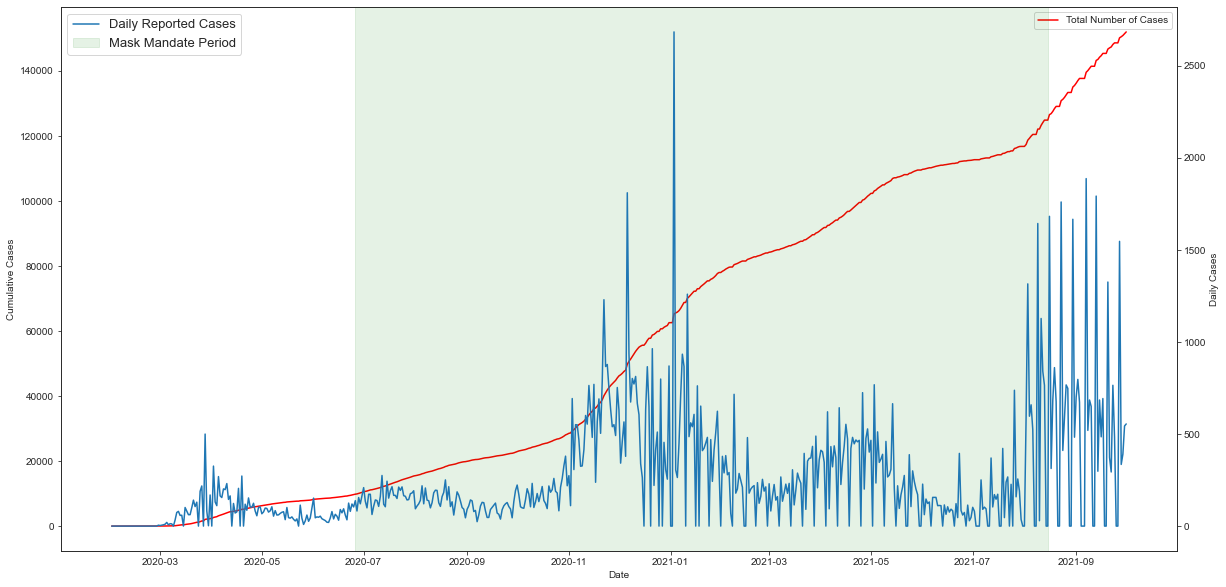

In [169]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
sns.set_style('ticks')
sns.lineplot(x="new_date_format", y="cases", data = kc_cases, ax=ax1, color='red', label='Total Number of Cases')
sns.lineplot(x="new_date_format", y="daily_cases", data = kc_cases, ax=ax2, label='Daily Reported Cases')
plt.axvspan(min(kc_mask_mandates['new_date_format']), max(kc_mask_mandates['new_date_format']), color='green', alpha=0.1, label='Mask Mandate Period')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Cases')
ax2.set_ylabel('Daily Cases')
plt.legend(fontsize=13)

We can see the overall trend of daily cases and cumulative cases in King County, WA. What is highly noticeable is the giant spike in daily cases around approximately January 2021. However, there are many errors or uncertainty within these plots. A concern would be looking at the number of cases at the daily level. When looking at the data closely, the bigger spikes seem to come in the beginning of the week which indicates that testing is more prevalent at these times (and is inconsistent overall). Testing doesn't seem to occur on the weekend or major holidays, which can cause a huge value in the number of daily cases. To alleviate that concern, we will look at the differences between cases on a bi-weekly scale.

- Rather than grouping the dates by every 14 days, it is important to ensure we account for weekends and holidays (since this would drive a difference in testing). Meaning we should look at our bi-weekly schedules in the standard manner, starting with a Sunday and ending with a Saturday.

In [173]:
# set biweekly week groups
# first instance we will set from Saturday 2/1/2020 - 2/15/2020
# the rest will be group starting from a sunday and ending with a saturday
for i in range(14):
    kc_cases['Week'].iloc[i] = 1
start = 15
count = 0
week_start = 2
for i in range(15, len(kc_cases)):
    if (count == 14):
        count = 0
        week_start = week_start + 1
    kc_cases['Week'].iloc[i] = week_start
    count = count + 1

C:\Users\rmvdo\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-173-60be873446c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_cases['Week'].iloc[i] = 1
<ipython-input-173-60be873446c0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_cases['Week'].iloc[i] = week_start


In [178]:
# get biweekly sums
kc_cases_bi_weekly = kc_cases.groupby(['Week'])['daily_cases'].sum()
kc_cases_bi_weekly

Week
1.0        0.0
2.0        5.0
3.0      381.0
4.0     1690.0
5.0     2185.0
6.0     1477.0
7.0     1208.0
8.0      722.0
9.0      812.0
10.0     734.0
11.0    1739.0
12.0    2194.0
13.0    2358.0
14.0    2119.0
15.0    2067.0
16.0    1313.0
17.0    1253.0
18.0    2016.0
19.0    2333.0
20.0    4613.0
21.0    7657.0
22.0    9075.0
23.0    9831.0
24.0    4797.0
25.0    9673.0
26.0    5757.0
27.0    3531.0
28.0    2473.0
29.0    2220.0
30.0    3402.0
31.0    4496.0
32.0    5419.0
33.0    5412.0
34.0    3157.0
35.0    2100.0
36.0    1337.0
37.0    1155.0
38.0    1503.0
39.0    2581.0
40.0    8095.0
41.0    8500.0
42.0    8064.0
43.0    7195.0
44.0    3372.0
Name: daily_cases, dtype: float64

In [177]:
kc_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,date,cases,new_date_format,daily_cases,Week
10,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",2/1/20,1.0,2020-02-01,0.0,1.0
11,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",2/2/20,1.0,2020-02-02,0.0,1.0
12,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",2/3/20,1.0,2020-02-03,0.0,1.0
13,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",2/4/20,1.0,2020-02-04,0.0,1.0
14,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",2/5/20,1.0,2020-02-05,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",9/27/21,150197.0,2021-09-27,1547.0,44.0
615,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",9/28/21,150532.0,2021-09-28,335.0,44.0
616,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",9/29/21,150923.0,2021-09-29,391.0,44.0
617,Washington,King,84053033,US,USA,840,53033.0,US,47.491379,-121.834613,"King, Washington, US",9/30/21,151467.0,2021-09-30,544.0,44.0
